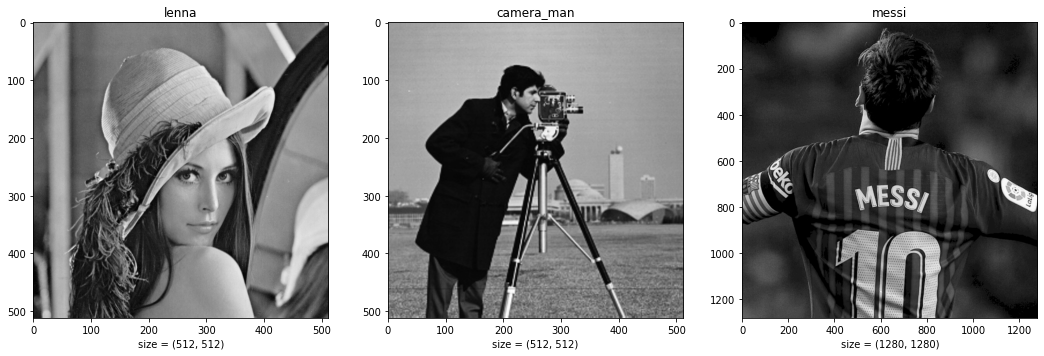

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2, cv2 as cv 

img_names = [ "lenna.png", "camera_man.png", "messi.png", ]

# 서브 챠트 생성 
chart_idx = 0 
fig, charts = plt.subplots( 1, len(img_names), figsize=(18, 17) )
charts = charts.ravel() 

for idx, img_name in enumerate(img_names) :
    chart = charts[ idx ]
    title = img_name.split( "." )[0]
    img = cv.imread( f"./image/{img_name}", 0 )
    chart.imshow( img, cmap='gray' )
    chart.set_title( title )
    chart.set_xlabel( f"size = {img.shape}")
pass

plt.show()


Hello...
Import done.

T = 10, K = 1 radius = 36.062445840513924
T = 10, K = 1 img_con size = (51, 51)
T = 10, K = 1 time elapsed = 2.6
****************************************
T = 10, K = 3 radius = 108.18733752154178
T = 10, K = 3 img_con size = (51, 51)
T = 10, K = 3 time elapsed = 23.8
****************************************
T = 10, K = 5 radius = 180.31222920256963
T = 10, K = 5 img_con size = (51, 51)
T = 10, K = 5 time elapsed = 70.1
****************************************
########################################
T = 20, K = 1 radius = 36.062445840513924
T = 20, K = 1 img_con size = (51, 51)
T = 20, K = 1 time elapsed = 14.6
****************************************
T = 20, K = 3 radius = 108.18733752154178
T = 20, K = 3 img_con size = (51, 51)
T = 20, K = 3 time elapsed = 128.6
****************************************
T = 20, K = 5 radius = 180.31222920256963
T = 20, K = 5 img_con size = (51, 51)
T = 20, K = 5 time elapsed = 354.8
****************************************
#####

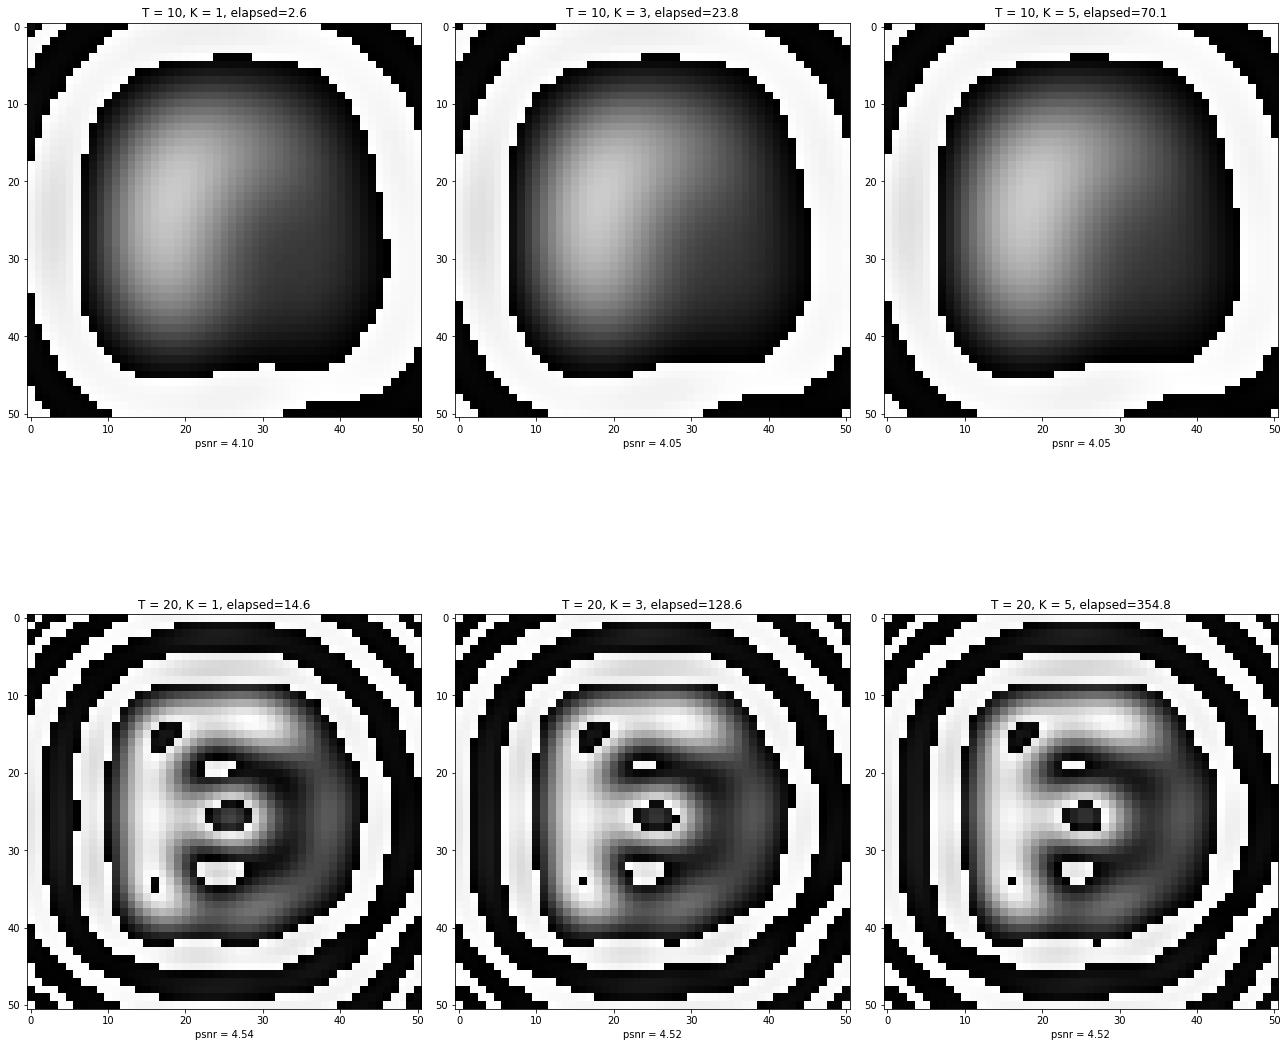


Good bye!.


In [2]:
print( "Hello..." )

import numpy as np, time, cv2, cv2 as cv, math
from matplotlib import pyplot as plt

# zernike code
from math import atan2
from numpy import cos, sin, conjugate, sqrt

print( "Import done.\n" )

def polar(theta):
    return 1.*cos(theta) + 1.j*sin(theta)
pass

facts = {}
facts[0] = 1.0

def factorial(n):
    if n in facts :
        return facts[n]
    else :
        f = n * factorial(n - 1)
        facts[n] = f
        return f
    pass
pass

poly_coeffs = {}

def poly_coeff(m, n, l) :
    key = f"{m}:{n}:{l}"
    if key in poly_coeffs :
        return poly_coeffs[ key ]
    else : 
        poly_coeff = (-1.0)**m * factorial(n-m) / ( factorial(m) * factorial((n - 2*m + l) // 2) * factorial((n - 2*m - l) // 2) )
        poly_coeffs[ key ] = poly_coeff
        
        return poly_coeff
    pass
pass
    
def zernike_poly(Y, X, n, l):    
    #y, x = Y[0], X[0]
    vxy = np.zeros(Y.size, dtype=complex)
    
    for index, (x, y) in enumerate( zip(X,Y) ):
        vnl = 0.0
        for m in range( int( (n-l)//2 + 1 ) ):
            vnl += poly_coeff( m, n, l ) * ( sqrt(x*x + y*y)**(n - 2*m) * polar( l*atan2(y,x) ) )
            #vnl += (-1.0)**m * factorial(n-m) / ( factorial(m) * factorial((n - 2*m + l) // 2) * factorial((n - 2*m - l) // 2) ) * \
            #    ( sqrt(x*x + y*y)**(n - 2*m) * polar(1.0, l*atan2(y,x)) )
        pass
    
        vxy[index] = vnl
    pass

    return vxy
pass # slow_zernike_poly

def zernike_reconstruct(img, T, K = 1):
    
    # image scale up
    shape = img.shape
    height = shape[0] ;  width = shape[1]
    img = cv2.resize( img, (width*K, height*K), interpolation= cv2.INTER_LINEAR)
    
    shape = img.shape
    rows, cols = shape
    radius = min( rows, cols )/2.0
    radius = math.sqrt( rows*rows + cols*cols )/2.0
    
    hdr = f"T = {T}, K = {K}"
    
    print( f"{hdr} radius = {radius}" )
    
    idx = np.ones(img.shape)

    y, x = np.where(idx > 0)
    
    p = img[y, x].ravel()
    yn = ( (y - rows/2.0)/radius ).ravel()
    xn = ( (x - cols/2.0)/radius ).ravel()

    k = (np.sqrt(xn**2 + yn**2) <= 1.)
    frac_center = np.array(p[k], np.double)
    
    yn = yn[k]
    xn = xn[k]
    frac_center = frac_center.ravel()

    # in the discrete case, the normalization factor is not pi but the number of pixels within the unit disk
    npix = float(frac_center.size)

    reconstr = np.zeros(img.size, dtype=complex)
    accum = np.zeros(yn.size, dtype=complex)

    for n in range( T + 1 ):
        for l in range( n + 1 ):
            if (n-l)%2 == 0:
                # get the zernike polynomial
                vxy = zernike_poly(yn, xn, float(n), float(l))
                # project the image onto the polynomial and calculate the moment
                a = sum(frac_center * conjugate(vxy)) * (n + 1)/npix
                # reconstruct
                accum += a * vxy
            pass
        pass
    pass

    reconstr[k] = accum
    
    return reconstr
pass # -- zernike_reconstruct 

# img_reconst
def img_reconst(img_name) :
    Ts = [ 10, 20 ]
    Ks = [ 1, 3, 5 ]
    
    # 서브 챠트 생성 
    chart_idx = 0 
    fig, charts = plt.subplots( len(Ts), len(Ks), figsize=(18, 18) )
    charts = charts.ravel() 

    # 이미지 읽기 
    img = cv.imread( f"./image/{img_name}", 0 )
    shape = img.shape
    
    width = 100
    if shape[1] > width : 
        img = cv2.resize( img, (width, shape[0]*width//shape[1]), interpolation= cv2.INTER_LINEAR)
    pass

    img_org = img
    height = img.shape[0]; width = img.shape[1]
    
    chart_idx = 0 
    
    for t_idx, T in enumerate( Ts ) :  
        for k_idx, K in enumerate( Ks ) : 
            # image reconstruct
            hdr = f"T = {T}, K = {K}"
            
            start_time = time.time()
                
            reconst = zernike_reconstruct( img, T, K )

            reconst = reconst.reshape( [height*K, width*K] )
            
            img_conv = reconst.real.astype( np.uint8 )
            img_conv = cv2.resize( img_conv, (width, height), interpolation= cv2.INTER_LINEAR)
            
            print( f"{hdr} img_con size = {img_conv.shape}" )
            
            elapsed = (time.time() - start_time)    
            print( f"{hdr} time elapsed = {elapsed:.1f}" )
            
            # psnr
            img_diff = img_conv.astype( np.float64 ) - img_org.astype( np.float64 )
                    
            gmax = np.max( img_diff ) + 0.0 # 복원된 이미지의 회색조 최대값
            mse = np.sum( np.square( img_diff )/img_diff.size ) + 0.0
            psnr = 10.0*math.log10(gmax*gmax/mse)
            
            # show image    
            chart = charts[ chart_idx ]
            title = f"{hdr}, elapsed={elapsed:.1f}"
            chart.imshow( img_conv, cmap='gray' )
            chart.set_title( title )
            chart.set_xlabel( f"psnr = {psnr:.2f}" )
            chart_idx += 1
            
            print( "*"*40)
        pass
    
        print( "#"*40)
    pass

    fig.tight_layout()
    plt.show()
pass # -- img_reconst


img_names = [ "lenna.png", "camera_man.png", "messi.png" ] 
img_names = [ "gl5un.png", "lenna.png", ] 

img_reconst( "gl5un.png" )
print( "\nGood bye!.")